In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/movie.csv


## **K-means Clustering: Understanding and Implementation**

### **What is K-means Clustering?**

K-means is a popular unsupervised machine learning algorithm used for **clustering**. It partitions a dataset into k clusters by iteratively refining the cluster centers (centroids). The goal of the algorithm is to minimize the **intra-cluster distance**, which is the sum of squared distances between each data point and its closest centroid. 

### **How does K-means work?**
1. **Initialization**:
   - Select k, the number of clusters with the help of the "elbow method".
   - Randomly initialize k centroids in the feature space.

2. **Assignment**:
   - Assign each data point to the nearest centroid based on a distance metric.

3. **Update**:
   - Compute the new centroids as the mean of all points assigned to each cluster.

4. **Repeat**:
   - Reassign data points to the nearest centroid and update centroids until convergence or the maximum number of iterations is reached.


### **What will we do in this notebook?**

1. **Select Features**: We will choose two features from the movie dataset that can be represented as a 2D plot.
2. **Choose K**: Choose k using the "Elbow Method" with the help of a graphical representation.
3. **K-means Algorithm**: Apply K-means clustering (the one developed in the second question) to the selected features.
4. **Visualize Clustering Progress**: Create a 2D plot to track the progression of clusters at each iteration.
5. **Final Clusters**: Display the final clusters and centroids after convergence.



## **Feature Selection**

### **Chosen Variables**
1. **Average Rating**: This variable represents the average rating given to a movie. It provides insight into how well a movie is received by users.
2. **Number of Reviews**: This variable represents the total number of reviews a movie has received. It indicates the popularity or engagement level of a movie.

### **Reason for Selection**
The two chosen variables were selected because they are:
- **Numerical**: Both variables are continuous and suitable for clustering using K-means, which relies on distance metrics.
- **Visually Distinctive**: Average ratings and the number of reviews capture different dimensions of user behavior, creating meaningful separations in the data.
- **Meaningful Clusters**: Combining popularity (number of reviews) with quality (average rating) is expected to result in clusters that group movies into categories such as "highly rated and popular" or "low-rated and niche."

By selecting these variables, we aim to create a 2D visualization that effectively demonstrates the progression of clusters across iterations. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv("/kaggle/input/movielens-20m-dataset/rating.csv")

# Group by movieId to calculate average rating and number of reviews
movie_stats = df.groupby("movieId").agg(
    average_rating=("rating", "mean"),
    num_reviews=("rating", "count"),
).reset_index()

# Rename movieId column for consistency
movie_stats.rename(columns={"movieId": "idmovie"}, inplace=True)

# Select features
features = ["average_rating", "num_reviews"]
X = movie_stats[features]

### **Why Standardize Variables?**
Before applying K-means, it is important to standardize the chosen variables because:
- **Different Scales**: The variables (e.g., `Average Rating` ranging from 0 to 5 and `Number of Reviews` ranging from 0 to thousands) have different scales. Without standardization, the variable with the larger range will dominate the clustering process.
- **Equal Contribution**: Standardization ensures that both variables contribute equally to the distance metric used by K-means, making the clustering more balanced and accurate.

We standardize the variables by transforming them to have a mean of 0 and a standard deviation of 1.

In [3]:
# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **Elbow Method**

### **What is the Elbow Method?**
The Elbow Method is a technique used to determine the optimal number of clusters (\( k \)) in a dataset. It involves plotting the **distortion (inertia)**, which is the sum of squared distances between points and their closest centroid, for different values of \( k \). The goal is to identify the "elbow point" in the graph where the distortion starts to decrease more slowly.


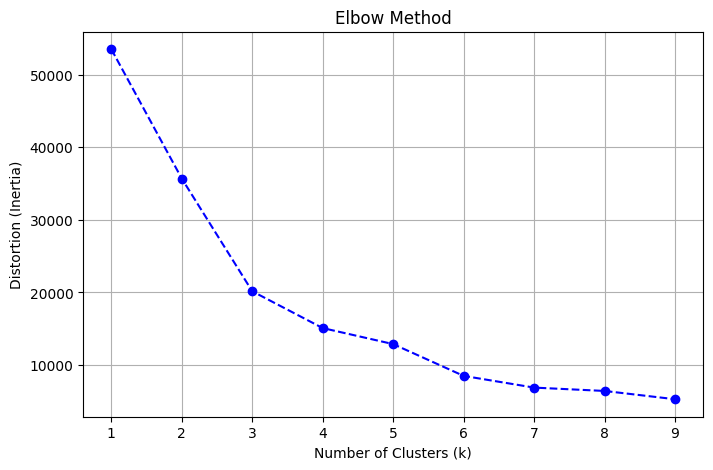

In [4]:
# Elbow Method to determine optimal number of clusters
distortions = []
k_values = range(1, 10)

for k in k_values:
    np.random.seed(42)
    initial_indices = np.random.choice(len(X_scaled), size=k, replace=False)
    centroids = X_scaled[initial_indices]
    
    for _ in range(10):  # 10 iterations for consistency
        distances = np.linalg.norm(X_scaled[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        centroids = np.array([X_scaled[labels == i].mean(axis=0) for i in range(k)])
    
    inertia = np.sum([
        np.sum((X_scaled[labels == i] - centroids[i])**2) for i in range(k)
    ])
    distortions.append(inertia)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, distortions, marker="o", linestyle="--", color="b")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion (Inertia)")
plt.grid(True)
plt.show()


### **Chosen Number of Clusters: k = 3**
From the Elbow Method plot:
1. The distortion decreases significantly as k increases from 1 to 3.
2. Beyond k = 3, the distortion decreases at a much slower rate, indicating that adding more clusters does not provide substantial benefits.

By choosing k = 3:
- We achieve a balance between simplicity (fewer clusters) and clustering accuracy (lower distortion).
- The resulting clusters are expected to group movies effectively based on their average ratings and number of reviews.

This choice allows us to create meaningful and interpretable clusters for the dataset.

## **Applying the Manual K-means Algorithm**

In this step, we apply the **K-means algorithm** developed in **Question 2** to the two selected variables:
1. **Average Rating**: The average rating of a movie, representing its quality as perceived by users.
2. **Number of Reviews**: The total number of reviews a movie has received, representing its popularity.

### **Why Use the Manual K-means Algorithm?**
The K-means algorithm implemented in Question 2 provides an opportunity to deeply understand the iterative process of clustering by manually controlling:
- The **assignment** of data points to clusters.
- The **recalculation** of cluster centroids.
- The **convergence criteria**, including the tolerance for centroid movement.

This approach ensures transparency and flexibility in clustering, making it easier to visualize and interpret how clusters form and evolve.

### **Goal**
We will:
1. Assign each movie (data point) to one of the three clusters identified earlier using the Elbow Method.
2. Track the movement of centroids and changes in cluster assignments over iterations.
3. Visualize the progression of clusters and the final clustering result.

By applying this manual K-means implementation, we aim to highlight the progression of clustering for these two selected features.


In [5]:
# Initialize K-means parameters
k = 3  # Number of clusters from the Elbow Method
num_iterations = 10
tolerance = 1e-4

# Randomly initialize centroids
np.random.seed(42)
initial_indices = np.random.choice(len(X_scaled), size=k, replace=False)
centroids = X_scaled[initial_indices]

# Helper functions
def assign_to_centroid(points, centroids):
    distances = np.linalg.norm(points[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def recompute_centroids(points, labels, k):
    return np.array([points[labels == i].mean(axis=0) for i in range(k)])

# Manual K-means implementation
centroids_history = [centroids]
labels_history = []

for iteration in range(num_iterations):
    # Assign points to the nearest centroid
    labels = assign_to_centroid(X_scaled, centroids)
    labels_history.append(labels)
    
    # Recompute centroids
    new_centroids = recompute_centroids(X_scaled, labels, k)
    centroids_history.append(new_centroids)
    
    # Check for convergence
    centroid_shift = np.linalg.norm(new_centroids - centroids)
    print(f"Iteration {iteration + 1}: Centroid shift = {centroid_shift:.4f}")
    if centroid_shift < tolerance:
        print(f"Converged after {iteration + 1} iterations.")
        break
    
    centroids = new_centroids

Iteration 1: Centroid shift = 2.0436
Iteration 2: Centroid shift = 0.8899
Iteration 3: Centroid shift = 0.5497
Iteration 4: Centroid shift = 0.4308
Iteration 5: Centroid shift = 0.3187
Iteration 6: Centroid shift = 0.2309
Iteration 7: Centroid shift = 0.1371
Iteration 8: Centroid shift = 0.0471
Iteration 9: Centroid shift = 0.0409
Iteration 10: Centroid shift = 0.0139


## **Visualizing the Clustering Progression**

### **Steps for Visualization**
To better illustrate the clustering process and highlight the changes across iterations, we use the following approach:

1. **Iteration 0 (Unclustered Points)**:
   - We begin by displaying the distribution of points before applying any clustering.
   - All points are shown in a neutral gray color to indicate the absence of clusters.

2. **Animated Iterations**:
   - Instead of showing separate static plots for each iteration, we create a slow-paced animation.
   - The animation highlights:
     - The gradual movement of centroids across iterations.
     - The evolving cluster assignments with distinct colors for each cluster.

3. **Direct Comparison**:
   - After the animation, we provide two side-by-side plots:
     - **Iteration 1**: The initial clustering result.
     - **Final Iteration**: The final clustering result after convergence.
   - This comparison helps visualize the radical differences between the initial and final stages of the algorithm.

### **Why This Approach?**
This method:
- Provides a clear understanding of how the clusters and centroids evolve.
- Makes it easier to grasp the iterative nature of K-means.
- Offers a visual representation of the improvement in clustering quality from start to finish.


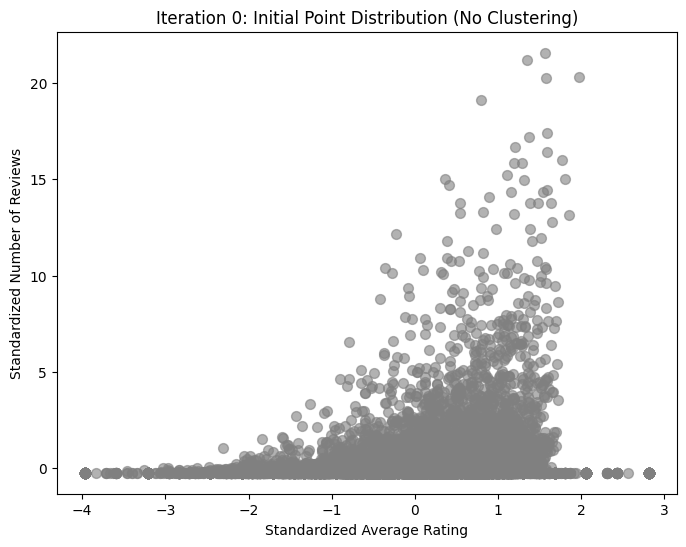

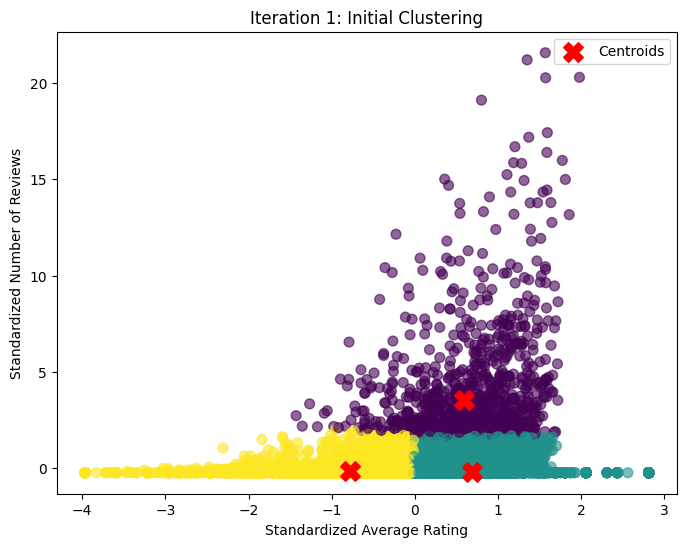

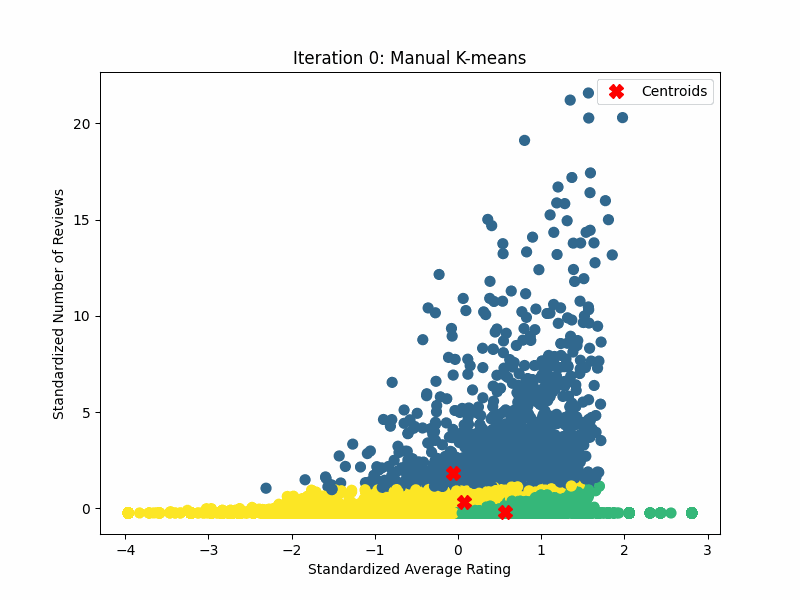

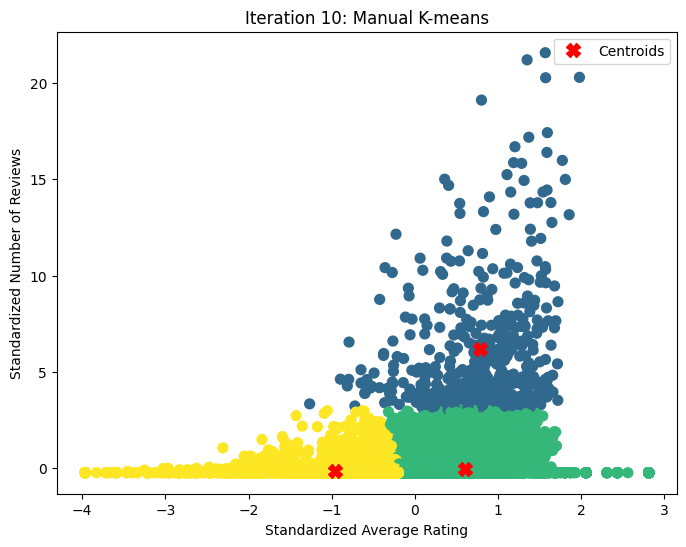

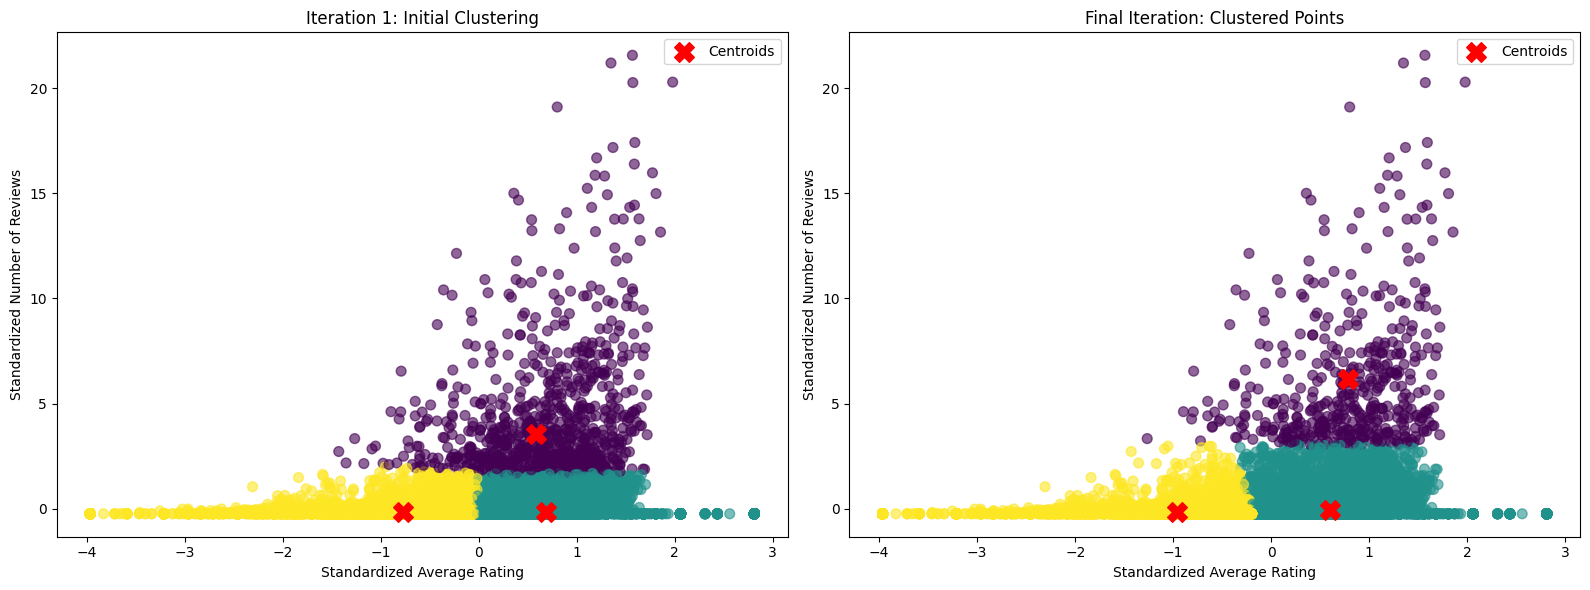

In [6]:
# Visualize Iteration 0
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], color="gray", alpha=0.6, s=50)
plt.title("Iteration 0: Initial Point Distribution (No Clustering)")
plt.xlabel("Standardized Average Rating")
plt.ylabel("Standardized Number of Reviews")
plt.show()

# Visualize Iteration 1
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_history[1], cmap='viridis', s=50, alpha=0.6)
plt.scatter(centroids_history[1][:, 0], centroids_history[1][:, 1], c="red", s=200, marker="X", label="Centroids")
plt.title("Iteration 1: Initial Clustering")
plt.xlabel("Standardized Average Rating")
plt.ylabel("Standardized Number of Reviews")
plt.legend()
plt.show()

from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.pyplot as plt

# Ensure centroids_history and labels_history are populated from the K-means function

# Initialize the plot for animation
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=np.zeros(len(X_scaled)), cmap='viridis', s=50)
centroids_plot, = ax.plot([], [], 'rX', markersize=10, label='Centroids')
ax.set_title("Cluster Animation (Manual K-means)")
ax.set_xlabel("Standardized Average Rating")
ax.set_ylabel("Standardized Number of Reviews")
ax.legend()

# Function to update the animation frame by frame
def update(frame):
    centroids = centroids_history[frame]
    labels = labels_history[frame] if frame < len(labels_history) else labels_history[-1]
    
    # Update scatter plot with the current labels
    scatter.set_array(labels)
    scatter.set_clim(-1, k - 1)  # Ensure consistent color mapping
    
    # Update centroids
    centroids_plot.set_data(centroids[:, 0], centroids[:, 1])
    
    ax.set_title(f"Iteration {frame}: Manual K-means")
    return scatter, centroids_plot

# Create the animation
anim = FuncAnimation(fig, update, frames=len(centroids_history), interval=1000, blit=False)

# Save the animation as a GIF
gif_path = "/kaggle/working/manual_kmeans_animation.gif"
anim.save(gif_path, writer=PillowWriter(fps=1))

# Display the animation
from IPython.display import Image
display(Image(filename=gif_path))

# Side-by-side comparison of Iteration 1 and Final Iteration
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Iteration 1
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_history[1], cmap="viridis", s=50, alpha=0.6)
axes[0].scatter(centroids_history[1][:, 0], centroids_history[1][:, 1], c="red", s=200, marker="X", label="Centroids")
axes[0].set_title("Iteration 1: Initial Clustering")
axes[0].set_xlabel("Standardized Average Rating")
axes[0].set_ylabel("Standardized Number of Reviews")
axes[0].legend()

# Final Iteration
axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_history[-1], cmap="viridis", s=50, alpha=0.6)
axes[1].scatter(centroids_history[-1][:, 0], centroids_history[-1][:, 1], c="red", s=200, marker="X", label="Centroids")
axes[1].set_title("Final Iteration: Clustered Points")
axes[1].set_xlabel("Standardized Average Rating")
axes[1].set_ylabel("Standardized Number of Reviews")
axes[1].legend()

plt.tight_layout()
plt.show()
